In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import seaborn as sns
import httpx
import json
from ast import literal_eval

In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.autolayout'] = True
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["axes.titlesize"] = 18
plt.rcParams["axes.labelsize"] = 16
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["xtick.labelsize"] = 14
plt.rcParams["ytick.labelsize"] = 14
plt.rcParams["axes.titlepad"] = 40

# Exploring IMBD's Top 250 Movies (August 2024)

## Data

In [3]:
df = pd.read_csv("IMDB_Top250.csv")

In [4]:
df

,title_id,name,poster,description,rating,rating_count,content_rating,genre,date_published,keywords,...,opening_weekend_gross_currency,aspect_ratios,colorations,spoken_languages,filming_locations,goofs,alternate_versions,prestigious_award_wins,prestigious_award_nominations,prestigious_award_type
0,tt0111161,The Shawshank Redemption,https://m.media-amazon.com/images/M/MV5BNDE3OD...,A Maine banker convicted of the murder of his ...,9.3,2935175,R,['Drama'],1994-10-14,"prison,based on the works of stephen king,esca...",...,USD,['1.85 : 1'],NaN,['English'],"Mansfield Reformatory - 100 Reformatory Road, ...",107,5,0,7,Oscar
1,tt0068646,The Godfather,https://m.media-amazon.com/images/M/MV5BNTc0ZD...,The aging patriarch of an organized crime dyna...,9.2,2045906,R,"['Crime', 'Drama']",1972-03-24,"mafia,patriarch,crime family,organized crime,g...",...,USD,['1.85 : 1'],Color,"['English', 'Italian', 'Latin']","Forza d'Agrò, Messina, Sicily, Italy",175,8,3,8,Oscar
2,tt0468569,The Dark Knight,https://m.media-amazon.com/images/M/MV5BMTMxNT...,When the menace known as the Joker wreaks havo...,9.0,2915611,PG-13,"['Action', 'Crime', 'Drama']",2008-07-25,"psychopath,superhero,moral dilemma,clown,crimi...",...,USD,['2.39 : 1'],Color,"['English', 'Mandarin']","Chicago, Illinois, USA",169,1,2,6,Oscar
3,tt0071562,The Godfather Part II,https://m.media-amazon.com/images/M/MV5BMWMwMG...,The early life and career of Vito Corleone in ...,9.0,1383317,R,"['Crime', 'Drama']",1974-12-18,"revenge,sicily,sicilian mafia,mother son relat...",...,USD,['1.85 : 1'],Color,"['English', 'Italian', 'Spanish', 'Latin', 'Si...","Kaiser Estate, 4000 W Lake Blvd, Homewood, Lak...",97,10,6,5,Oscar
4,tt0050083,12 Angry Men,https://m.media-amazon.com/images/M/MV5BMWU4N2...,The jury in a New York City murder trial is fr...,9.0,881539,B,"['Crime', 'Drama']",1957-04-10,"jury,murder,dialogue driven,trial,jury room",...,USD,['1.85 : 1'],Black and White,['English'],"New York County Courthouse - 60 Centre Street,...",26,1,0,3,Oscar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,tt0061512,Cool Hand Luke,https://m.media-amazon.com/images/M/MV5BNjcwNT...,A laid-back Southern man is sentenced to two y...,8.1,190594,Approved,"['Crime', 'Drama']",1967-11-01,"prison,fugitive,hard boiled egg,loss of mother...",...,USD,['2.35 : 1'],Color,['English'],"Jacksonville, Florida, USA",17,0,1,3,Oscar
246,tt0025316,It Happened One Night,https://m.media-amazon.com/images/M/MV5BMDg5Mm...,A rogue reporter trailing a runaway heiress fo...,8.1,113905,Approved,"['Comedy', 'Romance']",1934-02-22,"road movie,bus,reporter,road trip,haystack",...,USD,['1.37 : 1'],Black and White,['English'],"Busch Gardens - S. Grove Avenue, Pasadena, Cal...",30,0,5,0,Oscar
247,tt0103639,Aladdin,https://m.media-amazon.com/images/M/MV5BMmQwYW...,A kind-hearted street urchin and a power-hungr...,8.0,475614,G,"['Animation', 'Adventure', 'Comedy']",1992-11-25,"genie,three wishes,princess,prince,flying carpet",...,USD,"['1.78 : 1', '1.85 : 1']",Color,['English'],Walt Disney Feature Animation - 500 S. Buena V...,242,1,2,3,Oscar
248,tt0087884,"Paris, Texas",https://m.media-amazon.com/images/M/MV5BM2RjMm...,"Travis Henderson, an aimless drifter who has b...",8.1,123022,R,['Drama'],1984-08-23,"desert,possessive love,father son relationship...",...,USD,[],Color,"['English', 'Spanish']","Marathon Motel & RV Park - Highway 90, Maratho...",16,0,1,3,BAFTA Film Award


In [5]:
df["decade"] = df["release_year"].apply(lambda x: (x // 10) * 10)

In [6]:
exploded_countries = df.copy()
exploded_countries["countries"] = exploded_countries["countries"].apply(lambda x: literal_eval(str(x)))
exploded_countries = exploded_countries.explode("countries")

In [7]:
exploded_genres = df.copy()
exploded_genres["genre"] = exploded_genres["genre"].apply(lambda x: literal_eval(str(x)))
exploded_genres = exploded_genres.explode("genre")

## Ratings

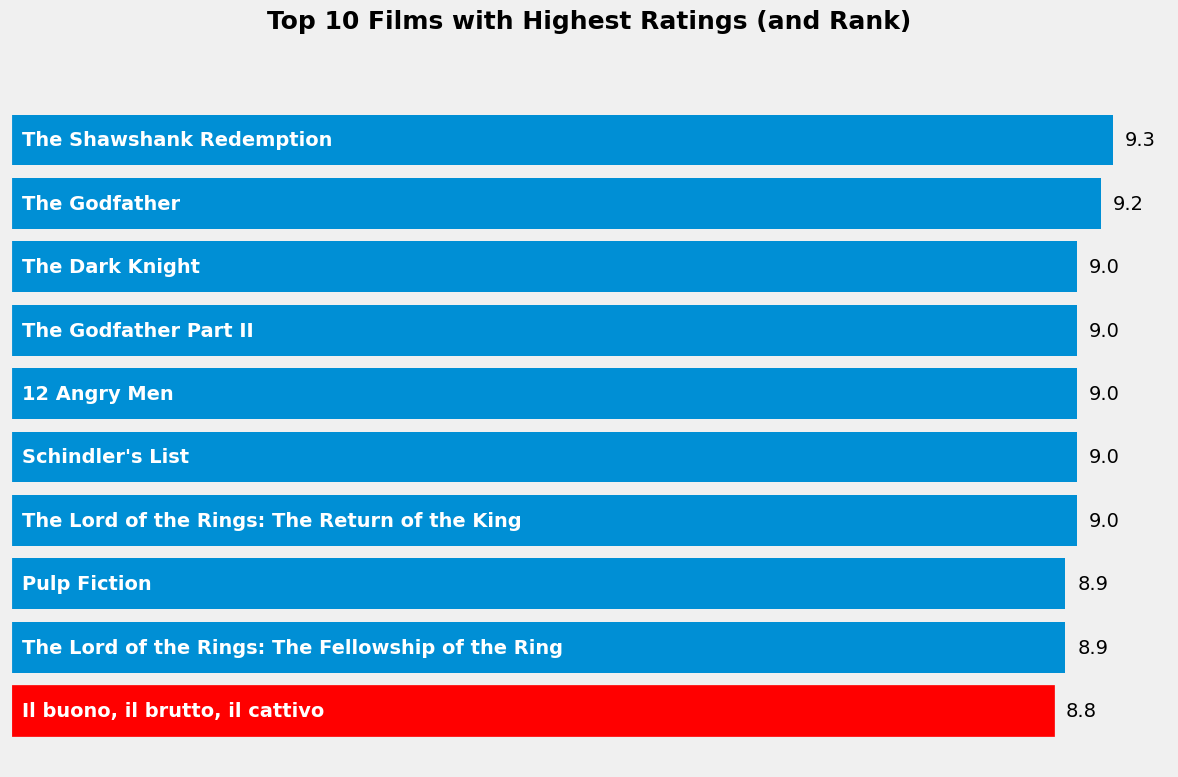

In [8]:
top_10 = df.sort_values(by="rank").head(10)

fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(visible=False)
bars = ax.barh(top_10["name"], top_10['rating'])
ax.set_title("Top 10 Films with Highest Ratings (and Rank)")
ax.invert_yaxis()
ax.set_xticks([])


bars[-1].set_color("red")
ax.get_yticklabels()[-1].set_color("red")

ax.set_yticks([])

for idx, bar in enumerate(bars):
    width = bar.get_width()  
    ax.text(width + 0.1,     
            bar.get_y() + bar.get_height()/2.,  
            f'{width:.1f}',  
            ha="left", va="center")
    
    y_position = bar.get_y() + bar.get_height() / 2
    
    ax.text(0.1,
            y_position,
            top_10["name"][idx],
            ha="left", va="center",  
            color="white",
            fontweight='bold')  


plt.savefig("viz/top-10-rank.png")
plt.show()

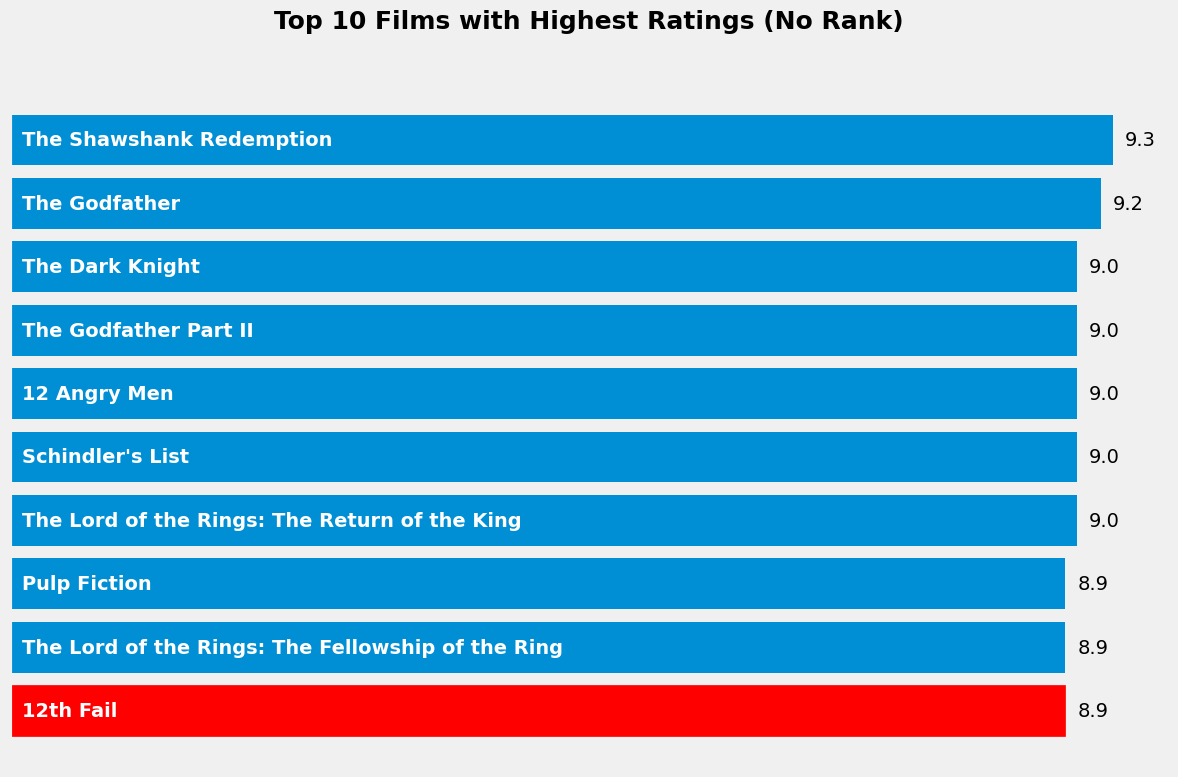

In [9]:
top_10 = df.sort_values(by="rating", ascending=False).head(10).reset_index()

fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(visible=False)
bars = ax.barh(top_10["name"], top_10['rating'])
ax.set_title("Top 10 Films with Highest Ratings (No Rank)")
ax.invert_yaxis()
ax.set_xticks([])


bars[-1].set_color("red")
ax.get_yticklabels()[-1].set_color("red")

ax.set_yticks([])

for idx, bar in enumerate(bars):
    width = bar.get_width()  
    ax.text(width + 0.1,     
            bar.get_y() + bar.get_height()/2.,  
            f'{width:.1f}',  
            ha="left", va="center")
    
    y_position = bar.get_y() + bar.get_height() / 2
    
    ax.text(0.1,
            y_position,
            top_10["name"][idx],
            ha="left", va="center",  
            color="white",
            fontweight='bold')  


plt.savefig("viz/top-10-no-rank.png")
plt.show()

In [10]:
df[df["name"].isin(["Il buono, il brutto, il cattivo", "12th Fail"])][["name", "rank", "rating", "rating_count"]]

,name,rank,rating,rating_count
9,"Il buono, il brutto, il cattivo",10,8.8,822301
59,12th Fail,60,8.9,127449


`12th Fail` has almost 7x less ratings, which is why it ranks way lower than `Il buono, il brutto, il cattivo` despite their equal average ratings

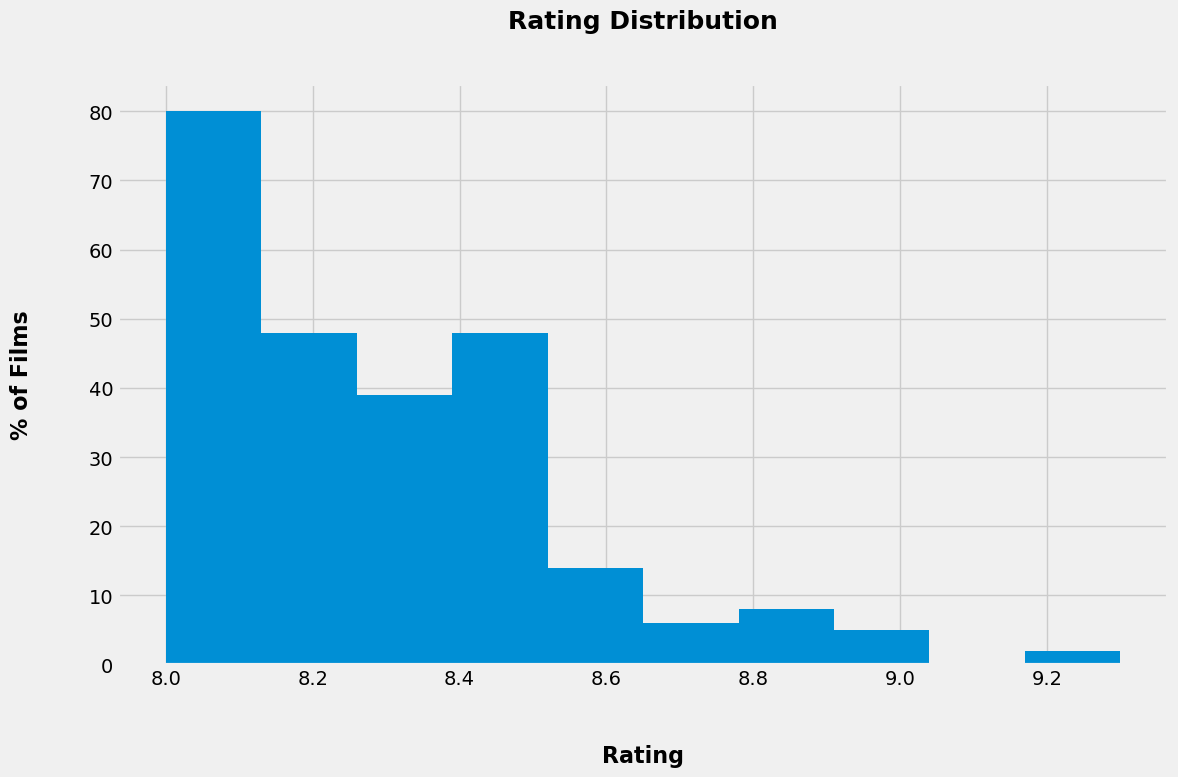

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(df["rating"])
ax.set_xlabel("Rating", labelpad=40)
ax.set_ylabel("% of Films", labelpad=40)
ax.set_title("Rating Distribution")
fig.savefig("viz/rating-distribution.png")
plt.show()

In [12]:
top_decades = df.groupby("decade").agg({
    "title_id": "count",
    "rating": "mean",
    "metascore": "mean"
})

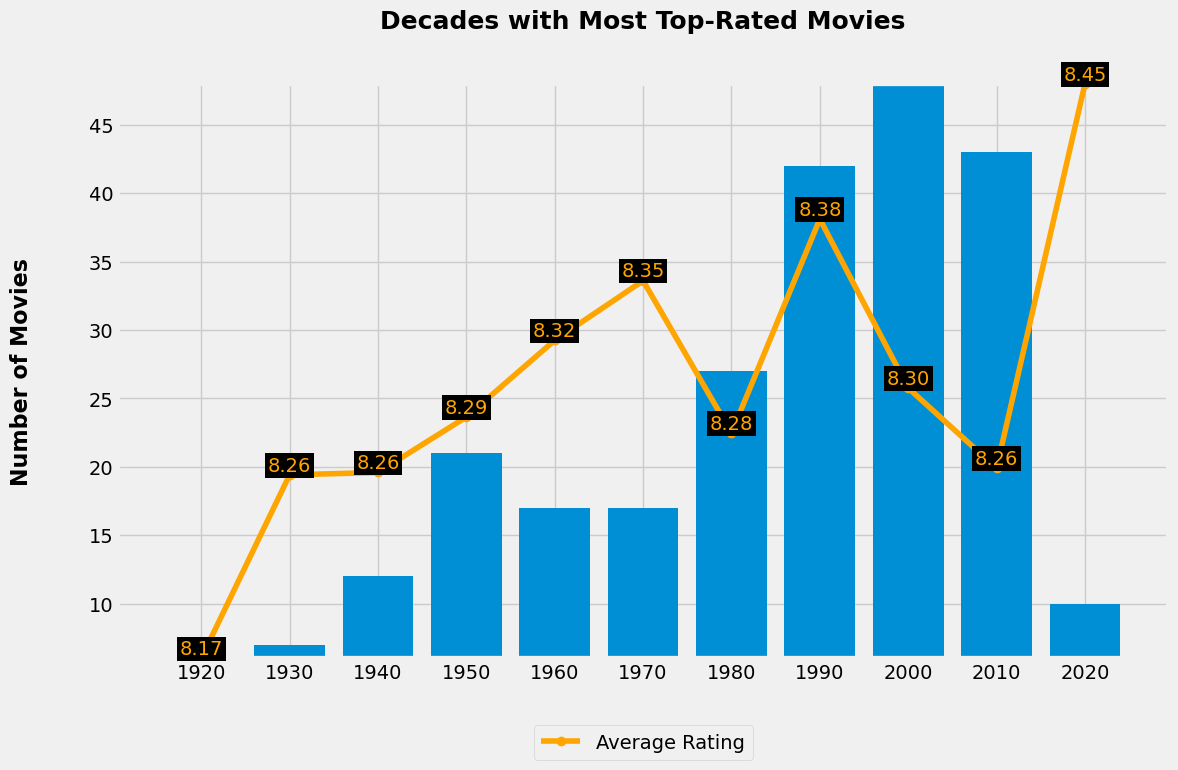

In [13]:
fig, ax1 = plt.subplots(figsize=(12, 8))
bars = ax1.bar(top_decades.index.astype(int).astype(str), top_decades["title_id"])
ax2 = ax1.twinx()

points = ax2.plot(top_decades.index.astype(int).astype(str), top_decades["rating"], c="orange", marker='o', linestyle='-', label="Average Rating")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax1.set_title("Decades with Most Top-Rated Movies")
ax1.set_ylabel("Number of Movies", labelpad=40)
ax1.set_ylim([top_decades["title_id"].min(), top_decades["title_id"].max()])
ax2.set_ylim([top_decades["rating"].min(), top_decades["rating"].max()])
ax2.set_yticks([])
for x, y in zip(top_decades.index.astype(int).astype(str), top_decades["rating"]):
    ax2.text(
        x,
        y,
        f"{y:.2f}",
        va='bottom',
        ha='center',
        fontsize=14,
        color='orange',
        bbox=dict(facecolor='black', edgecolor='none', pad=2)
    )
plt.show()

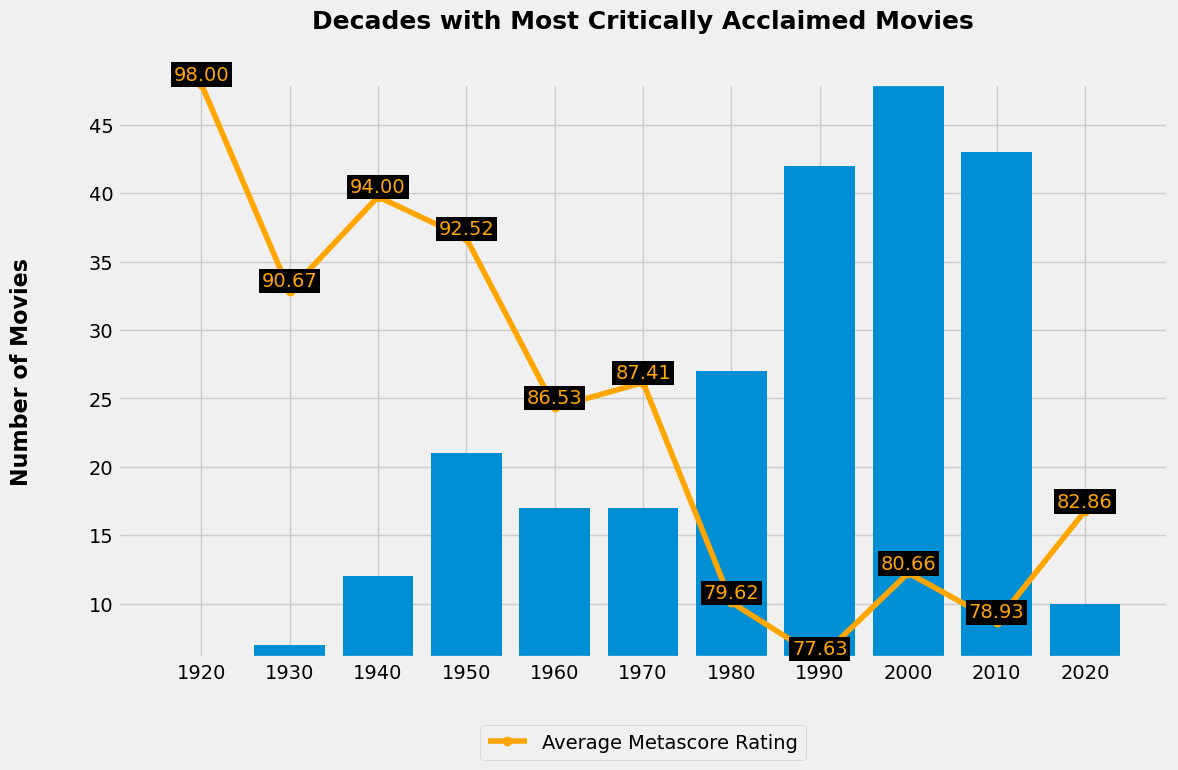

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 8))
bars = ax1.bar(top_decades.index.astype(int).astype(str), top_decades["title_id"])
ax2 = ax1.twinx()

points = ax2.plot(top_decades.index.astype(int).astype(str), top_decades["metascore"], c="orange", marker='o', linestyle='-', label="Average Metascore Rating")
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
ax1.set_title("Decades with Most Critically Acclaimed Movies")
ax1.set_ylabel("Number of Movies", labelpad=40)
ax1.set_ylim([top_decades["title_id"].min(), top_decades["title_id"].max()])
ax2.set_ylim([top_decades["metascore"].min(), top_decades["metascore"].max()])
ax2.set_yticks([])
for x, y in zip(top_decades.index.astype(int).astype(str), top_decades["metascore"]):
    ax2.text(
        x,
        y,
        f"{y:.2f}",
        va='bottom',
        ha='center',
        fontsize=14,
        color='orange',
        bbox=dict(facecolor='black', edgecolor='none', pad=2)
    )
plt.show()

Universally Acclaimed Films (sorted by rating, metascore, and prestigious award wins)

In [15]:
df.sort_values(by=["rating", "metascore", "prestigious_award_wins"], ascending=False).dropna()[["rank", "name", "rating", "metascore", "prestigious_award_wins"]].head(10)

,rank,name,rating,metascore,prestigious_award_wins
1,2,The Godfather,9.2,100.0,3
4,5,12 Angry Men,9.0,97.0,0
5,6,Schindler's List,9.0,95.0,7
6,7,The Lord of the Rings: The Return of the King,9.0,94.0,11
3,4,The Godfather Part II,9.0,90.0,6
2,3,The Dark Knight,9.0,84.0,2
7,8,Pulp Fiction,8.9,95.0,1
8,9,The Lord of the Rings: The Fellowship of the Ring,8.9,92.0,4
11,12,The Lord of the Rings: The Two Towers,8.8,87.0,2
10,11,Forrest Gump,8.8,82.0,6


## Awards

In [16]:
most_oscars = df[df["prestigious_award_type"] == "Oscar"].sort_values(by="prestigious_award_wins", ascending=False).head(10)

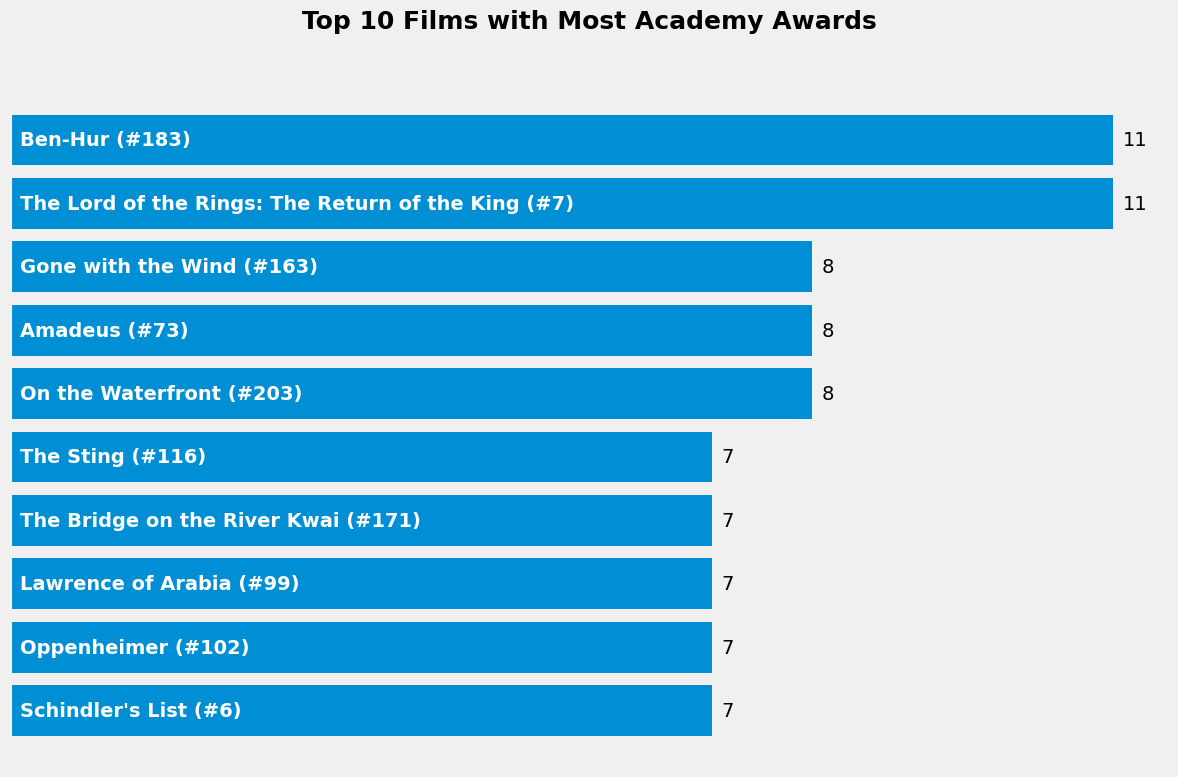

In [17]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(visible=False)
bars = ax.barh(most_oscars["name"], most_oscars["prestigious_award_wins"])
ax.set_title("Top 10 Films with Most Academy Awards")
ax.invert_yaxis()
ax.set_xticks([])

ax.set_yticks([])

for idx, bar in enumerate(bars):
    width = bar.get_width()  
    ax.text(width + 0.1,     
            bar.get_y() + bar.get_height()/2.,  
            most_oscars["prestigious_award_wins"].iloc[idx],
            ha="left", va="center")
    
    y_position = bar.get_y() + bar.get_height() / 2
    
    ax.text(0.1,
            y_position,
            f"{most_oscars['name'].iloc[idx]} (#{most_oscars['rank'].iloc[idx]})",
            ha="left", va="center",  
            color="white",
            fontweight='bold')  


plt.savefig("viz/most-oscars.png")
plt.show()

In [18]:
no_major_awards = df[df["prestigious_award_type"].isna()].sort_values(by="rank").head(10)

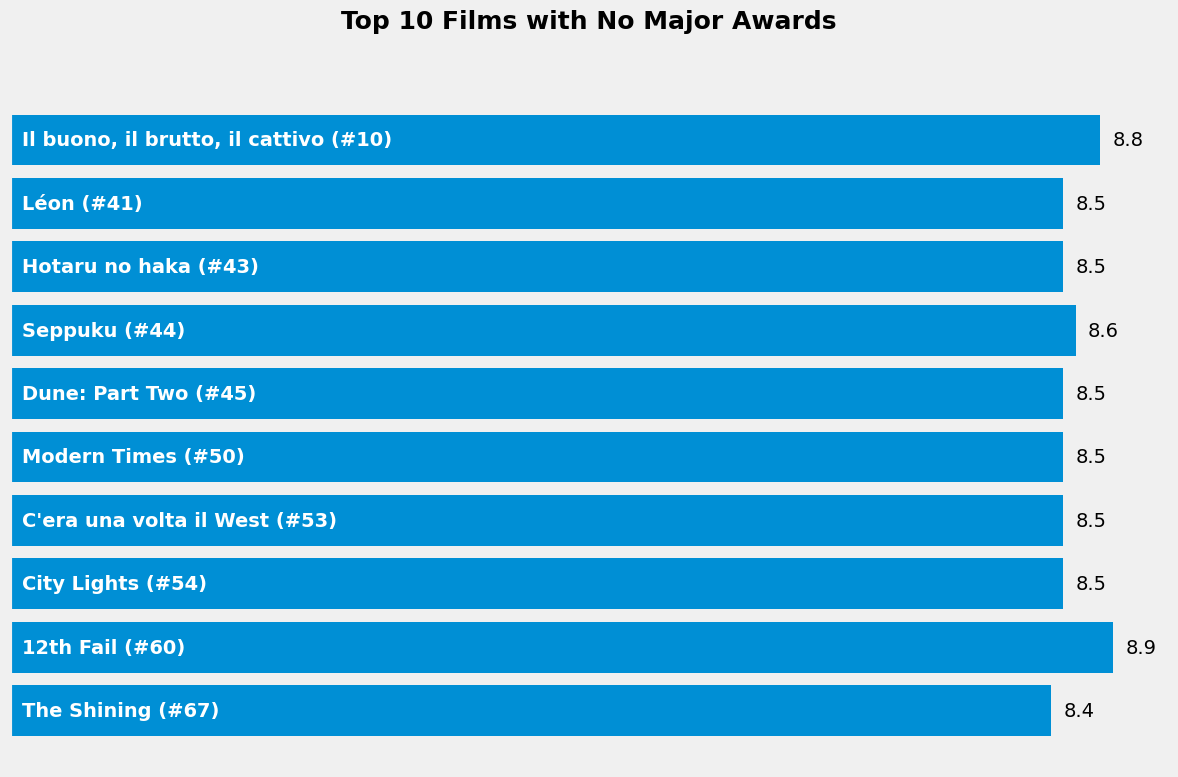

In [19]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(visible=False)
bars = ax.barh(no_major_awards["name"], no_major_awards["rating"])
ax.set_title("Top 10 Films with No Major Awards")
ax.invert_yaxis()
ax.set_xticks([])

ax.set_yticks([])

for idx, bar in enumerate(bars):
    width = bar.get_width()  
    ax.text(width + 0.1,     
            bar.get_y() + bar.get_height()/2.,  
            f'{width:.1f}',  
            ha="left", va="center")
    
    y_position = bar.get_y() + bar.get_height() / 2
    
    ax.text(0.1,
            y_position,
            f"{no_major_awards['name'].iloc[idx]} (#{no_major_awards['rank'].iloc[idx]})",
            ha="left", va="center",  
            color="white",
            fontweight='bold')  


plt.savefig("viz/no-major-awards.png")
plt.show()

In [20]:
no_awards = df[(df["wins"] == 0)].sort_values(by="rank").head(10)

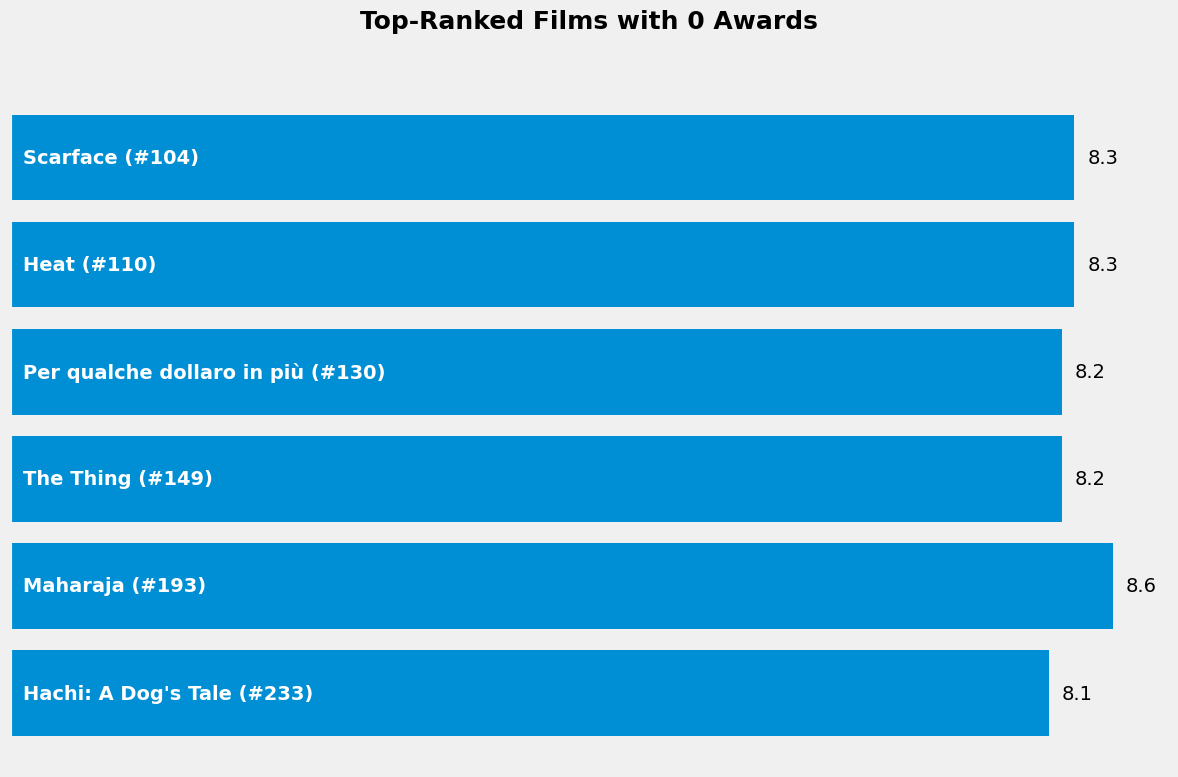

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(visible=False)
bars = ax.barh(no_awards["name"], no_awards["rating"])
ax.set_title("Top-Ranked Films with 0 Awards")
ax.invert_yaxis()
ax.set_xticks([])

ax.set_yticks([])

for idx, bar in enumerate(bars):
    width = bar.get_width()  
    ax.text(width + 0.1,     
            bar.get_y() + bar.get_height()/2.,  
            f'{width:.1f}',  
            ha="left", va="center")
    
    y_position = bar.get_y() + bar.get_height() / 2
    
    ax.text(0.1,
            y_position,
            f"{no_awards['name'].iloc[idx]} (#{no_awards['rank'].iloc[idx]})",
            ha="left", va="center",  
            color="white",
            fontweight='bold')  


plt.savefig("viz/no-awards.png")
plt.show()

In [22]:
df["win_ratio"] = df["wins"] / (df["wins"] + df["nominations"])

In [23]:
highest_win_ratio = df.sort_values(by="win_ratio", ascending=False).head(10)

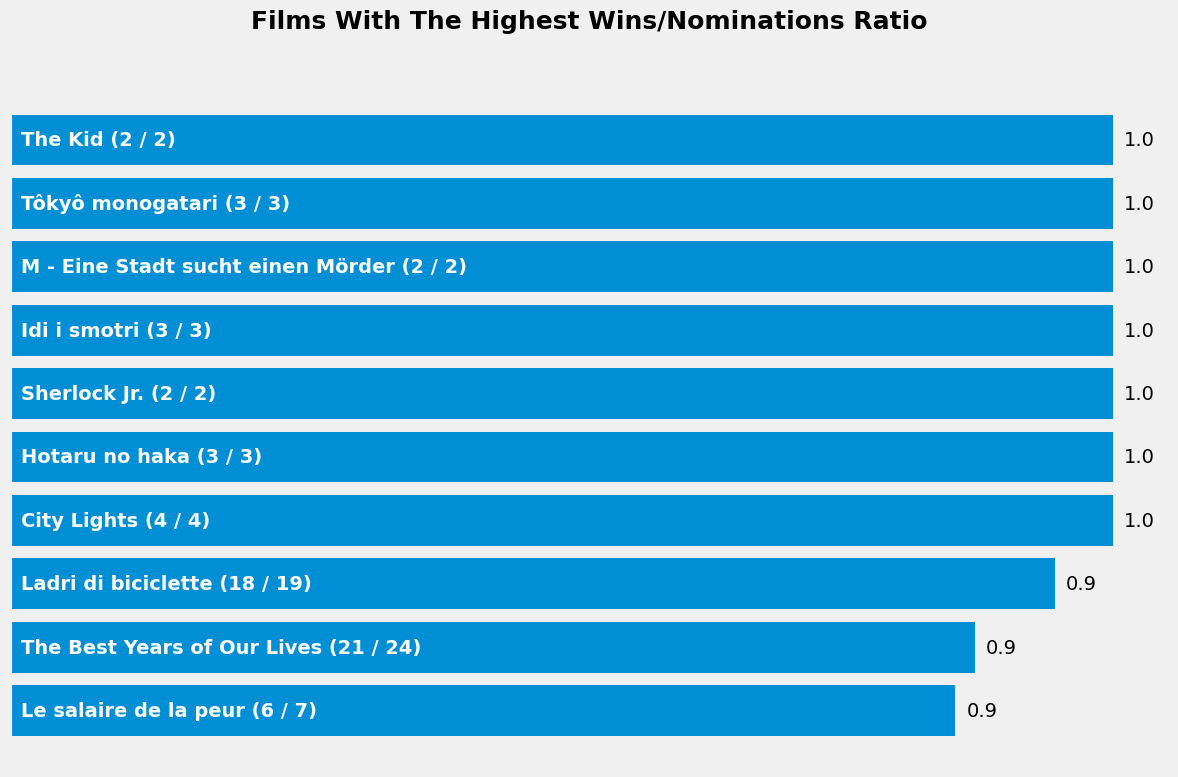

In [24]:
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(visible=False)
bars = ax.barh(highest_win_ratio["name"], highest_win_ratio["win_ratio"])
ax.set_title("Films With The Highest Wins/Nominations Ratio")
ax.invert_yaxis()
ax.set_xticks([])
ax.set_yticks([])

for idx, bar in enumerate(bars):
    width = bar.get_width()  
    ax.text(width + 0.01,     
            bar.get_y() + bar.get_height()/2.,  
            f'{width:.1f}',  
            ha="left", va="center")
    
    y_position = bar.get_y() + bar.get_height() / 2
    
    ax.text(0.01,
            y_position,
            f"{highest_win_ratio['name'].iloc[idx]} ({highest_win_ratio['wins'].iloc[idx]} / {highest_win_ratio['wins'].iloc[idx] + highest_win_ratio['nominations'].iloc[idx]})",
            ha="left", va="center",  
            color="white",
            fontweight='bold')  


plt.savefig("viz/highest-win-ratio.png")
plt.show()

In [25]:
countries_with_most_oscars = exploded_countries[exploded_countries["prestigious_award_type"] == "Oscar"]\
.groupby("countries").agg({"prestigious_award_wins": "sum", "prestigious_award_nominations": "sum"})\
.sort_values(by="prestigious_award_wins", ascending=False).head(10)

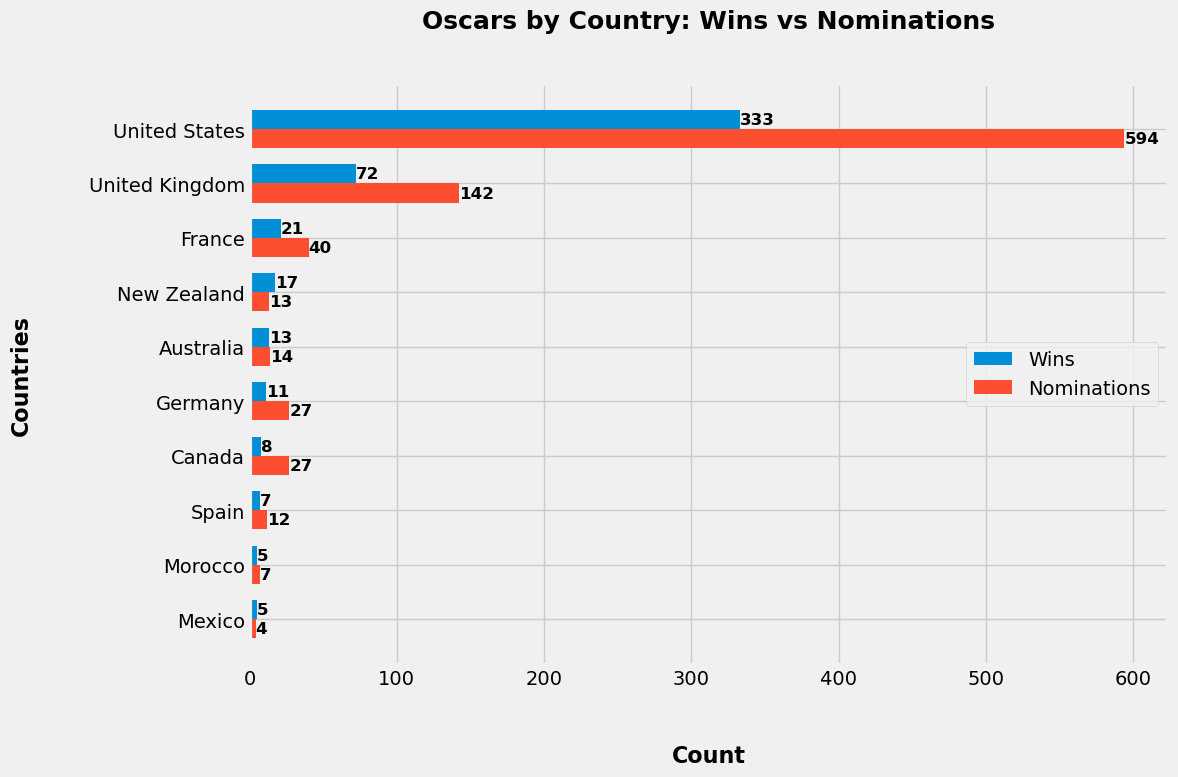

In [26]:
bar_height = 0.35

y = np.arange(len(countries_with_most_oscars))

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.barh(y - bar_height/2, countries_with_most_oscars["prestigious_award_wins"], bar_height, label='Wins')
bars2 = ax.barh(y + bar_height/2, countries_with_most_oscars["prestigious_award_nominations"], bar_height, label='Nominations')

def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                ha='left', va='center', fontweight='bold', fontsize=12)

add_labels(bars1)
add_labels(bars2)

ax.set_ylabel('Countries', labelpad=40)
ax.set_xlabel('Count', labelpad=40)
ax.set_title('Oscars by Country: Wins vs Nominations')
ax.set_yticks(y)
ax.set_yticklabels(countries_with_most_oscars.index)
ax.invert_yaxis()
ax.legend(loc="center right")

plt.tight_layout()
plt.savefig("viz/oscars-by-country.png")
plt.show()


In [27]:
countries_with_most_awards = exploded_countries.groupby("countries")\
.agg({"wins": "sum", "nominations": "sum"})\
.sort_values(by="wins", ascending=False).head(10)

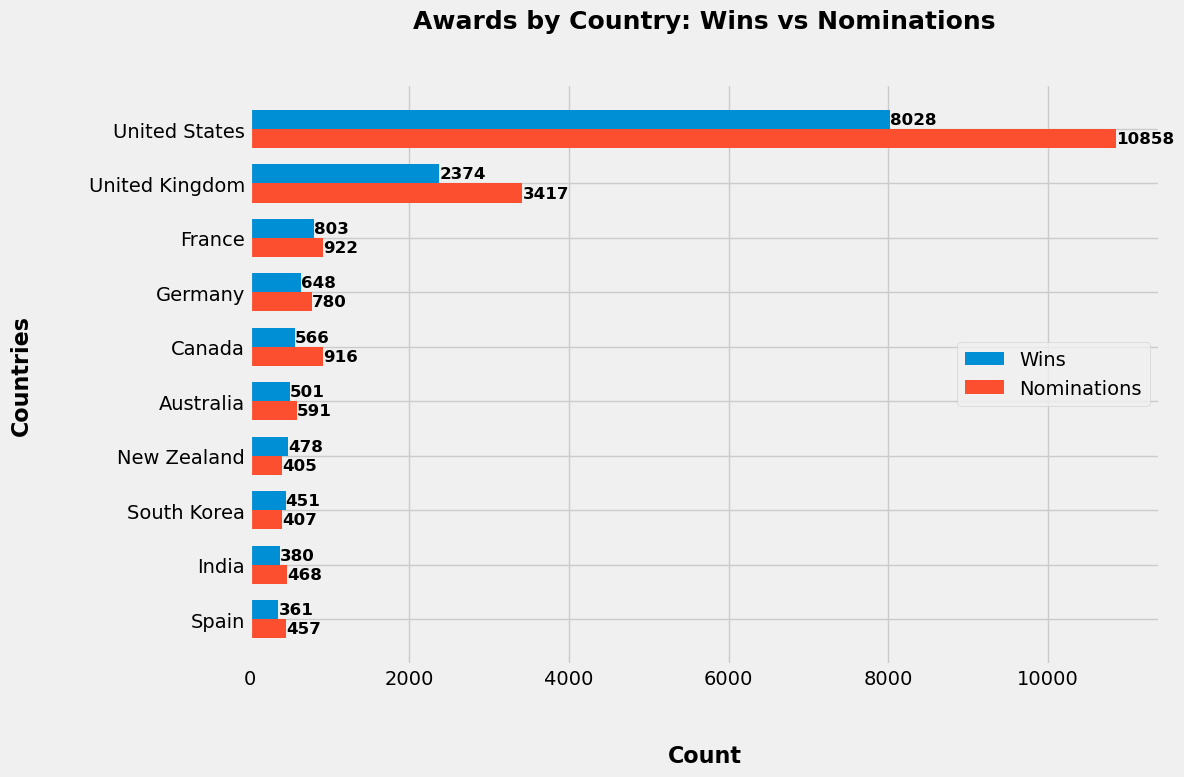

In [28]:
bar_height = 0.35

y = np.arange(len(countries_with_most_awards))

fig, ax = plt.subplots(figsize=(12, 8))
bars1 = ax.barh(y - bar_height/2, countries_with_most_awards["wins"], bar_height, label='Wins')
bars2 = ax.barh(y + bar_height/2, countries_with_most_awards["nominations"], bar_height, label='Nominations')

def add_labels(bars):
    for bar in bars:
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, f'{int(width)}', 
                ha='left', va='center', fontweight='bold', fontsize=12)

add_labels(bars1)
add_labels(bars2)

ax.set_ylabel('Countries', labelpad=40)
ax.set_xlabel('Count', labelpad=40)
ax.set_title('Awards by Country: Wins vs Nominations')
ax.set_yticks(y)
ax.set_yticklabels(countries_with_most_awards.index)
ax.invert_yaxis()
ax.legend(loc="center right")

plt.tight_layout()
plt.savefig("viz/awards-by-country.png")
plt.show()


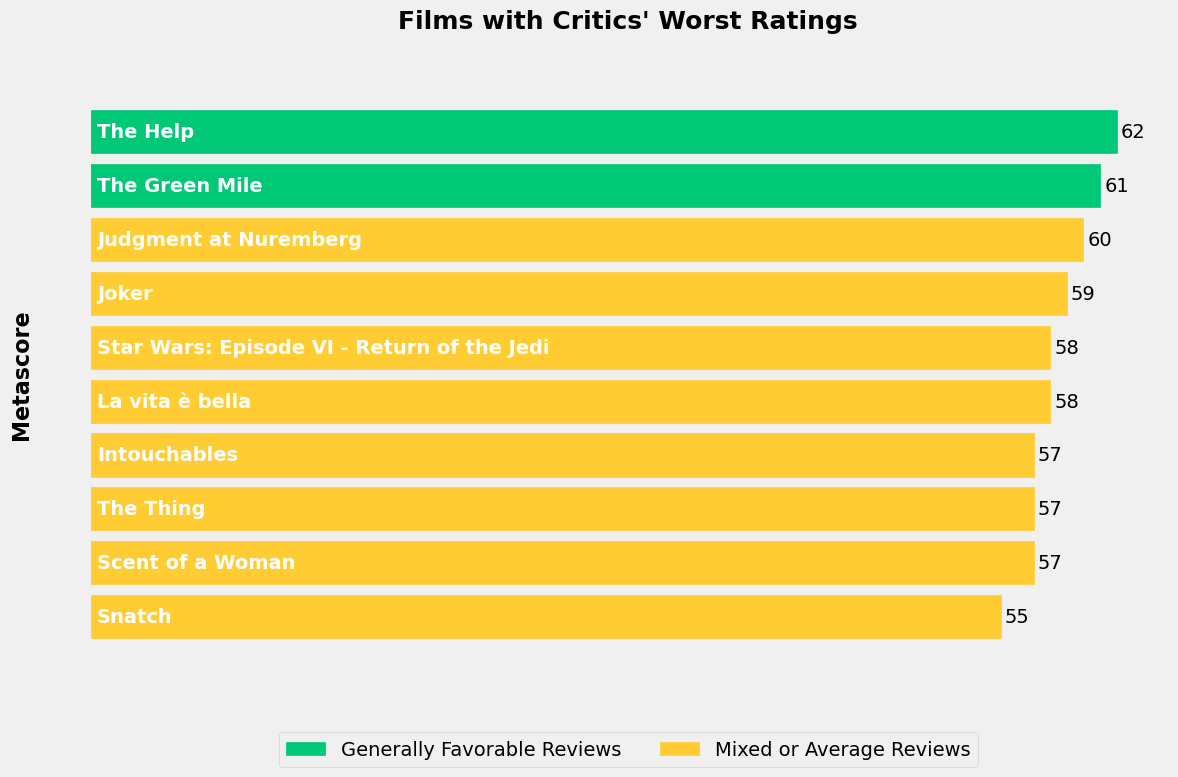

In [29]:
critics_lowest_ratings = df.sort_values(by="metascore").head(10)
fig, ax = plt.subplots(figsize=(12, 8))
plt.grid(visible=False)
bars = ax.barh(critics_lowest_ratings["name"], critics_lowest_ratings["metascore"])
ax.set_title("Films with Critics' Worst Ratings")
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel("Metascore", labelpad=40)

for idx, bar in enumerate(bars):
    width = bar.get_width()  
    metascore = critics_lowest_ratings["metascore"].iloc[idx]
    if 80 >= metascore >= 61:
        bar.set_color("#00C877")


    if 40 <= metascore <= 60:
        bar.set_color("#FFCC33")
        
    
    ax.text(width + 0.25,     
            bar.get_y() + bar.get_height()/2.,  
            int(metascore),
            ha="left", va="center")
    
    y_position = bar.get_y() + bar.get_height() / 2
    
    ax.text(0.5,
            y_position,
            f"{critics_lowest_ratings['name'].iloc[idx]}",
            ha="left", va="center",  
            color="white",
            fontweight='bold')  


legend_labels = [
    mpatches.Patch(color='#00C877', label='Generally Favorable Reviews'),
    mpatches.Patch(color='#FFCC33', label='Mixed or Average Reviews'),
]

ax.legend(handles=legend_labels, loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=3)



plt.savefig("viz/critics-lowest_ratings.png")
plt.show()

## Genres

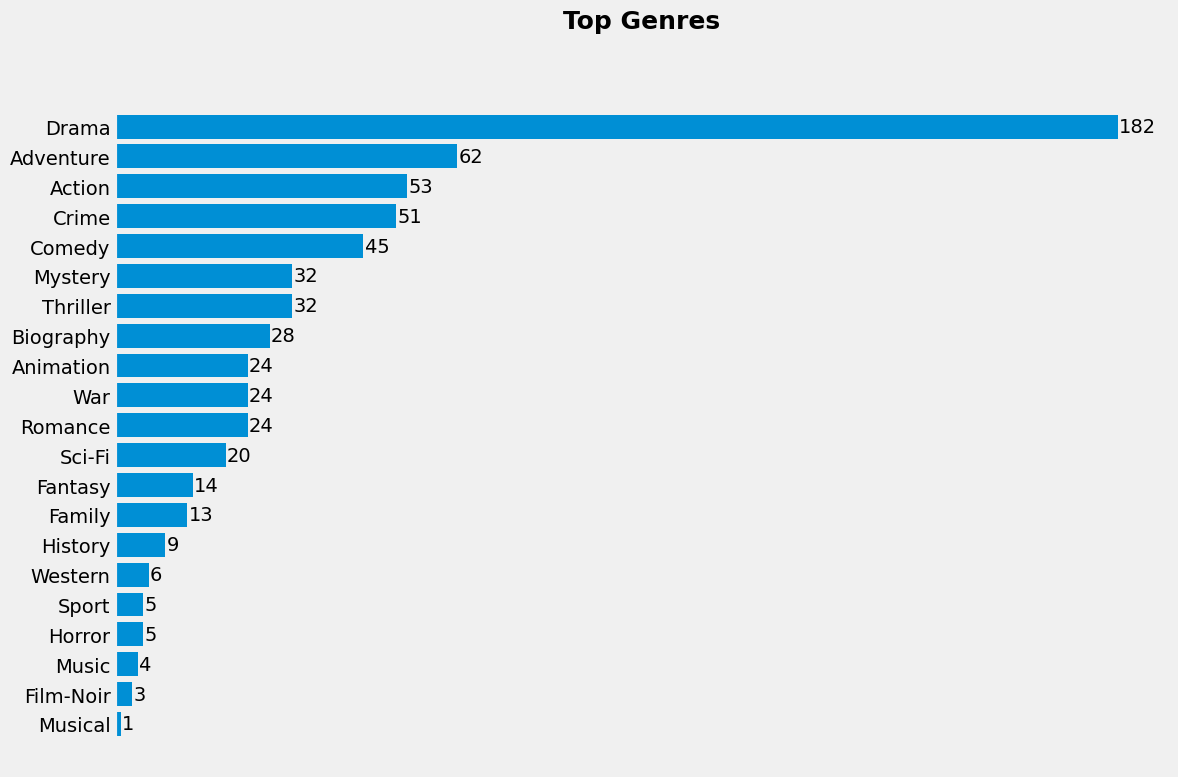

In [30]:
top_genres = exploded_genres.groupby("genre").size().sort_values(ascending=False)
bars = ax.barh(top_genres.index, top_genres.values)
ax.set_title("Top Genres")
ax.set_xticks([])
ax.invert_yaxis()

for idx, bar in enumerate(bars):
    width = bar.get_width()  

  
    ax.text(width + 0.25,     
            bar.get_y() + bar.get_height()/2.,  
            top_genres.values[idx],
            ha="left", va="center")

plt.show()

In [109]:
top_genres_by_decade = exploded_genres.groupby(["decade", "genre"]).agg({"genre": "count"})

In [112]:
top_genres_by_decade

genre
decade genre           
1920   Action         2
       Adventure      2
       Biography      1
       Comedy         4
       Drama          4
...                 ...
2020   Crime          2
       Drama          8
       Fantasy        1
       History        2
       Mystery        2

[148 rows x 1 columns]

ValueError: RGBA sequence should have length 3 or 4

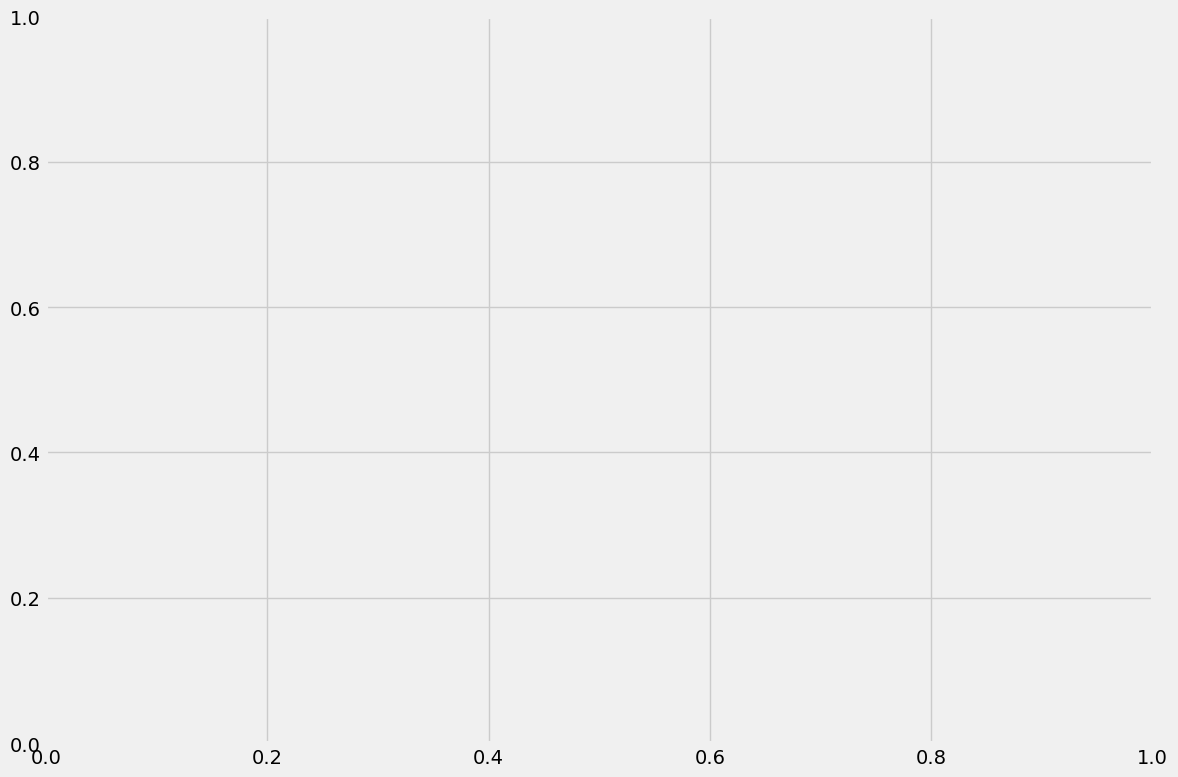

In [128]:
fig, ax = plt.subplots(figsize=(12, 8))
used_labels = set()
sorted_data = sorted(top_genres_by_decade.index, key=lambda x: x[0])
bottoms = np.zeros(len(set(year for year, _ in sorted_data)))
years = sorted(set(year for year, _ in sorted_data))
year_to_x = {year: i for i, year in enumerate(years)}

for genre_data, value in zip(sorted_data, top_genres_by_decade.values):
    year, genre = genre_data
    x = year_to_x[year]
    
    label = genre if genre not in used_labels else ""
    ax.bar(x, value[0], bottom=bottoms[x], label=label, width=0.8, color=)
    
    # Update the bottom for the next bar in this stack
    bottoms[x] += value[0]
    
    # Add this label to the set of used labels
    used_labels.add(genre)

# Set the x-axis labels to be the years
ax.set_xticks(range(len(years)))
ax.set_xticklabels(years, rotation=45)

# Add labels and title
ax.set_xlabel('Decade')
ax.set_ylabel('Count')
ax.set_title('Top Genres by Decade')

# Add legend
ax.legend(title='Genre', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to prevent cutting off labels
plt.tight_layout()

# Show the plot
plt.show()